# Bayesian ARMA model

This notebook shows how Bayesian [ARMA model](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model#Applications) can be implemeted in **RxInfer.jl**

For theoretical details on Varitional Inference for ARMA model, we refer the reader to the following [paper](https://ieeexplore.ieee.org/document/7798432)

The Bayesian ARMA model can be written as follows:


$$e_t \sim \mathcal{N}(0, \gamma^{-1})$$
$${\theta} \sim \mathcal{MN}(\mathbf{0}, \mathbf{I})$$
$${\eta} \sim \mathcal{MN}(\mathbf{0}, \mathbf{I})$$
$$\mathbf{h}_t = \mathbf{S}\mathbf{h}_{t-1} + \mathbf{c} e_{t-1}$$
$$\mathbf{x}_t = \boldsymbol{\theta}^\top\mathbf{x}_{t-1} + \boldsymbol{\eta}^\top\mathbf{h}_{t} + e_t$$

where shift matrix $\mathbf{S}$ is
$$\mathbf{S} = \begin{pmatrix}
0 & 0 \\
1 & 0 
\end{pmatrix}$$
and unit vector $\mathbf{c}$: $$\mathbf{c}=[1, 0]$$ when MA order is $2$

In this way, errors $e_t$ can be viewed as hidden states.

In short, the Bayesian ARMA model has two intractabilities: (1) induced by the multiplication of two Gaussian RVs, i.e., $\boldsymbol{\eta}^\top\mathbf{h}_{t}$, (2) induced by errors $e_t$ that prevents analytical update of precision parameter $\gamma$ (this can be easily seen when constructing the Factor Graph, i.e. there is a loop)

Both problems can be easily resolved in **RxInfer.jl**, by creating a hybrid inference algorithm based on Loopy Variational Message Passing.

In [1320]:
# Load packages
using RxInfer, LinearAlgebra, CSV, DataFrames, Plots

In [1321]:
# Define shift function
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [1324]:
@model function ARMA(n, x_prev, h_prior, γ_prior, τ_prior, η_prior, θ_prior, p, q)
        
    c = zeros(p); c[1] = 1.0; # AR
    b = zeros(q); b[1] = 1.0; # MA
    S = shift(q); # MA
    
    # initialize variables
    h  = randomvar(n-1)
    e  = randomvar(n)
    z  = randomvar(n)
    
    x  = datavar(Float64, n) where { allow_missing = true }
    
    # priors
    γ  ~ GammaShapeRate(shape(γ_prior), rate(γ_prior))
    η  ~ MvNormalMeanPrecision(mean(η_prior), precision(η_prior))
    θ  ~ MvNormalMeanPrecision(mean(θ_prior), precision(θ_prior))
    τ  ~ GammaShapeRate(shape(τ_prior), rate(τ_prior))
    
    # initial
    h_0  ~ MvNormalMeanPrecision(mean(h_prior), precision(h_prior))
    z[1] ~ AR(h_0, η, τ) where {meta=ARMeta(Multivariate, q, ARsafe())}
    e[1] ~ NormalMeanPrecision(0.0, γ)

    x[1] ~ dot(b, z[1]) + dot(θ, x_prev[1]) + e[1]
    
    h_prev = h_0
    for t in 1:n-1
        
        e[t+1] ~ NormalMeanPrecision(0.0, γ)
        h[t] ~ S*h_prev + b*e[t]
        z[t+1] ~ AR(h[t], η, τ) where {meta=ARMeta(Multivariate, q, ARsafe())}
        x[t+1] ~ dot(z[t+1], b) + dot(θ, x_prev[t]) + e[t+1]
        h_prev = h[t]
    end
end

### Download dataset

To validate our model and inference, we will use the S&P 500 stock data from [Kaggle](https://www.kaggle.com/code/purvasingh/time-series-analysis-with-arma-and-arima/data?select=all_stocks_5yr.csv)

Once the dataset is downloaded, we can load it into DataFrame.

In [1325]:
x_df = CSV.read("data/all_stocks_5yr.csv", DataFrame);

In [1326]:
# we will use "close" column
# for the sake of example, we will use only 200 entries out of 619040
x_data = filter(!ismissing, x_df[:, 5])[1:200];

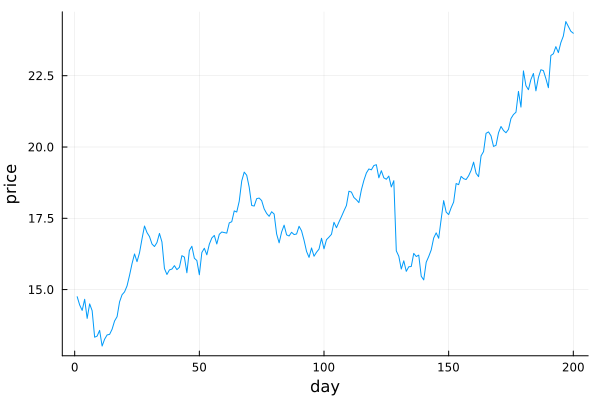

In [1327]:
plot(x_data, xlabel="day", ylabel="price", label=false)

In [1329]:
# Constraints are needed for performing VMP
arma_constraints = @constraints begin
    q(z, h_0, h, η, τ, γ,e) = q(h_0)q(z, h)q(η)q(τ)q(γ)q(e)
end;

In [1330]:
arma_imarginals = (h_0 = h_prior, h = h_prior, γ = γ_prior, τ = τ_prior, η = η_prior, θ = θ_prior);
arma_imessages  = (h_0 = h_prior, h = h_prior);

In [1331]:
p_order = 5 # AR
q_order = 4 # MA
h_prior = MvNormalMeanPrecision(zeros(q_order), diageye(q_order))
γ_prior = GammaShapeRate(1e4, 1.0)
τ_prior = GammaShapeRate(1e2, 1.0)
η_prior = MvNormalMeanPrecision(zeros(q_order), diageye(q_order))
θ_prior = MvNormalMeanPrecision(zeros(p_order), diageye(p_order));

In [1332]:
# Training set
train_size = 100
x_prev_train = [Float64.(x_data[i+p_order-1:-1:i]) for i in 1:length(x_data)-p_order][1:train_size]
x_train = Float64.(x_data[p_order+1:end])[1:train_size];

In [1333]:
# Test set
x_prev_test = [Float64.(x_data[i+p_order-1:-1:i]) for i in 1:length(x_data)-p_order][train_size+1:end]
x_test = Float64.(x_data[p_order+1:end])[train_size+1:end];

In [1334]:
# First execution is slow due to Julia's init compilation 
result = inference(
    model = ARMA(length(x_train), x_prev_train, h_prior, γ_prior, τ_prior, η_prior, θ_prior, p_order, q_order), 
    data  = (x = x_train, ),
    free_energy = false, # we are not interested in the free energy in this experiment
    initmarginals = arma_imarginals,
    initmessages  = arma_imessages,
    constraints   = arma_constraints,
    iterations    = 50,
    options       = (limit_stack_depth = 100, ),
    showprogress  = true
);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


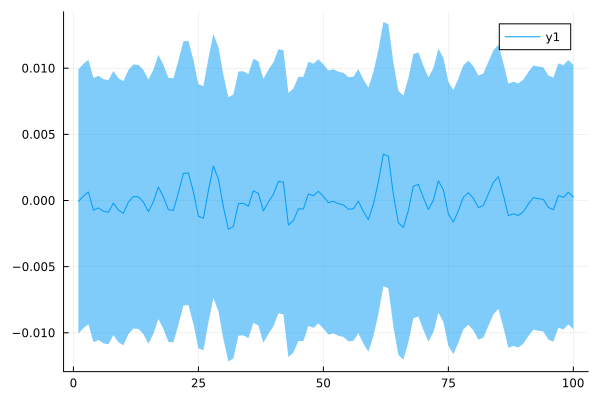

In [1335]:
plot(mean.(result.posteriors[:e][end]), ribbon=std.(result.posteriors[:e][end]))

In [1336]:
# extract posteriors
h_posterior = result.posteriors[:h][end][end]
γ_posterior = result.posteriors[:γ][end]
τ_posterior = result.posteriors[:τ][end]
η_posterior = result.posteriors[:η][end]
θ_posterior = result.posteriors[:θ][end];

In [1337]:
# The prediction function is aimed at approximating the predictive posterior distribution
# It triggers the rules in the generative order (in future, RxInfer will provide this function out of the box)
function prediction(x_prev, h_posterior, γ_posterior, τ_posterior, η_posterior, θ_posterior, p, q)
    h_out = MvNormalMeanPrecision(mean(h_posterior), precision(h_posterior))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=h_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, p, ARsafe()))
    c = zeros(p); c[1] = 1.0
    b = zeros(q); b[1] = 1.0
    ar_dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(b), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    θ_out = MvNormalMeanPrecision(mean(θ_posterior), precision(θ_posterior))
    ma_dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(x_prev), m_in2=θ_out, meta=ReactiveMP.TinyCorrection())
    e_out = @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=PointMass(0.0), q_τ=mean(γ_posterior))
    ar_ma = @call_rule typeof(+)(:out, Marginalisation) (m_in1=ar_dot_out, m_in2=ma_dot_out)  
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=ar_ma, m_in2=e_out)  
end

prediction (generic function with 1 method)

In [1338]:
predictions = []
for x_prev in x_prev_test
    push!(predictions, prediction(x_prev, h_posterior, γ_posterior, τ_posterior, η_posterior, θ_posterior, p_order, q_order))
    # after every new prediction we can actually "retrain" the model to use the power of Bayesian approach
    # we will skip this part for now
end

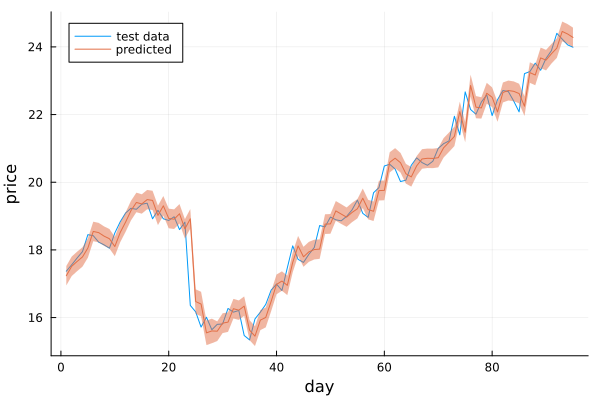

In [1339]:
plot(x_test, label="test data", legend=:topleft)
plot!(mean.(predictions)[1:end], ribbon=std.(predictions)[1:end], label="predicted", xlabel="day", ylabel="price")